In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# Data

In [2]:
import seaborn as sns
data = sns.load_dataset('iris')
df = torch.tensor(data.drop(columns="species").values).float()
labels = torch.zeros(len(df), dtype=torch.long)
labels[data.species == 'versicolor'] = 1 
labels[data.species == 'virginica'] = 2

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df, labels, train_size=0.7)
tf_train = TensorDataset(x_train, y_train)
tf_test = TensorDataset(x_test, y_test)
train = DataLoader(tf_train, batch_size=16, shuffle=True)
test = DataLoader(tf_test, batch_size=tf_test.tensors[0].shape[0])

In [4]:
tf_train.tensors[0][:10]

tensor([[5.6000, 3.0000, 4.1000, 1.3000],
        [5.8000, 2.7000, 4.1000, 1.0000],
        [5.8000, 2.7000, 3.9000, 1.2000],
        [7.0000, 3.2000, 4.7000, 1.4000],
        [5.0000, 3.3000, 1.4000, 0.2000],
        [5.2000, 3.4000, 1.4000, 0.2000],
        [4.9000, 2.4000, 3.3000, 1.0000],
        [5.0000, 3.2000, 1.2000, 0.2000],
        [7.6000, 3.0000, 6.6000, 2.1000],
        [7.7000, 3.0000, 6.1000, 2.3000]])

In [5]:
tf_train.tensors[1][:10]

tensor([1, 1, 1, 1, 0, 0, 1, 0, 2, 2])

In [15]:
def model(l2lambda):
    ann = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64,3)
    )
    lossfn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ann.parameters(), lr=0.05, weight_decay=l2lambda)
    return ann, lossfn, optimizer

In [16]:
ann, lossfn, optimizer = model(0.1)

In [17]:
def train_model():    
    numepochs = 1000
    trainacc = []
    testacc = []
    losses = []
    for i in range(numepochs):
        batchloss = []
        batchacc = []
        for x, y in train:
            yhat = ann(x)
            loss = lossfn(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchacc.append(100*torch.mean((torch.argmax(yhat, axis=1)== y).float()).item())
            batchloss.append(loss.item())
        trainacc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))
        testx, testy = next(iter(test)) 
        pred = torch.argmax(ann(testx), axis=1)
        testacc.append(100*torch.mean((pred==testy).float()).item())
    return trainacc, testacc, losses

In [18]:
trainacc, testacc, losses = train_model()

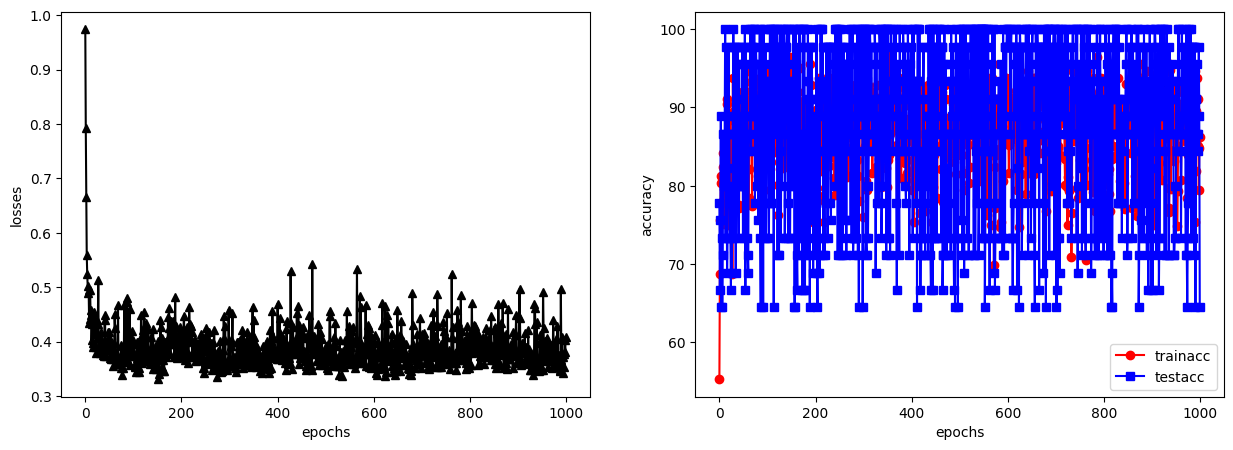

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(losses,'k^-')
ax[0].set_ylabel("losses")
ax[0].set_xlabel("epochs")
ax[1].plot(trainacc, "ro-")
ax[1].plot(testacc, "bs-")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epochs")
ax[1].legend(['trainacc', 'testacc'])

# Experiment

In [20]:
lambdas = np.linspace(0, 0.1, 10)
numepochs = 1000

In [21]:
trainaccmatrix = np.zeros((len(lambdas), numepochs))
testaccmatrix = np.zeros((len(lambdas), numepochs))

In [22]:
for i in range(len(lambdas)):
    ann, lossfn, optimizer = model(lambdas[i])
    trainaccmatrix[i:], testaccmatrix[i:], _ = train_model() 

In [23]:
trainaccmatrix

array([[34.52380981, 68.45238124, 66.36904776, ..., 99.10714286,
        97.32142857, 98.21428571],
       [30.25793689, 65.57539701, 66.66666695, ..., 97.32142857,
        96.42857143, 96.62698422],
       [42.55952409, 61.30952409, 73.80952409, ..., 82.14285714,
        95.73412708, 97.32142857],
       ...,
       [50.59523838, 59.32539701, 71.32936546, ..., 91.96428571,
        88.39285714, 95.53571429],
       [49.40476205, 67.95634925, 76.78571429, ..., 81.64682559,
        74.90079403, 85.01984136],
       [57.34126994, 70.03968273, 70.93253987, ..., 85.41666695,
        87.5       , 81.15079403]])

In [24]:
testaccmatrix

array([[ 64.44444656,  64.44444656,  73.33333492, ..., 100.        ,
        100.        , 100.        ],
       [ 26.66666806,  73.33333492, 100.        , ..., 100.        ,
        100.        ,  88.88888955],
       [ 26.66666806,  88.88888955,  64.44444656, ..., 100.        ,
         97.77777791, 100.        ],
       ...,
       [ 26.66666806,  64.44444656,  86.66666746, ...,  97.77777791,
         88.88888955, 100.        ],
       [ 84.44444537,  91.11111164,  64.44444656, ...,  97.77777791,
         88.88888955,  66.66666865],
       [ 64.44444656,  64.44444656,  64.44444656, ...,  86.66666746,
         73.33333492,  64.44444656]])